In [1]:
from utils.Dataset import SeqDataset
from torchvision import transforms

filepath1 = "../080524/analysis/2024_0805_152322g6actin804-HP-50ms_4x4_4800_blue128.tif"
filepath2 = "../080524/analysis/2024_0805_152322g6actin804-HP-50ms_4x4_4800_violet128.tif"
runrestpath = "../080524/080524-804-2_runrest.csv"

runrest = []

import csv
with open(runrestpath, newline='') as csvfile:
    line = csv.reader(csvfile, delimiter=',')
    for row in line:
        runrest.append(row)

runrest = list(map(int, runrest[0]))

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = SeqDataset(filepath1, filepath2, runrest, transform, True)

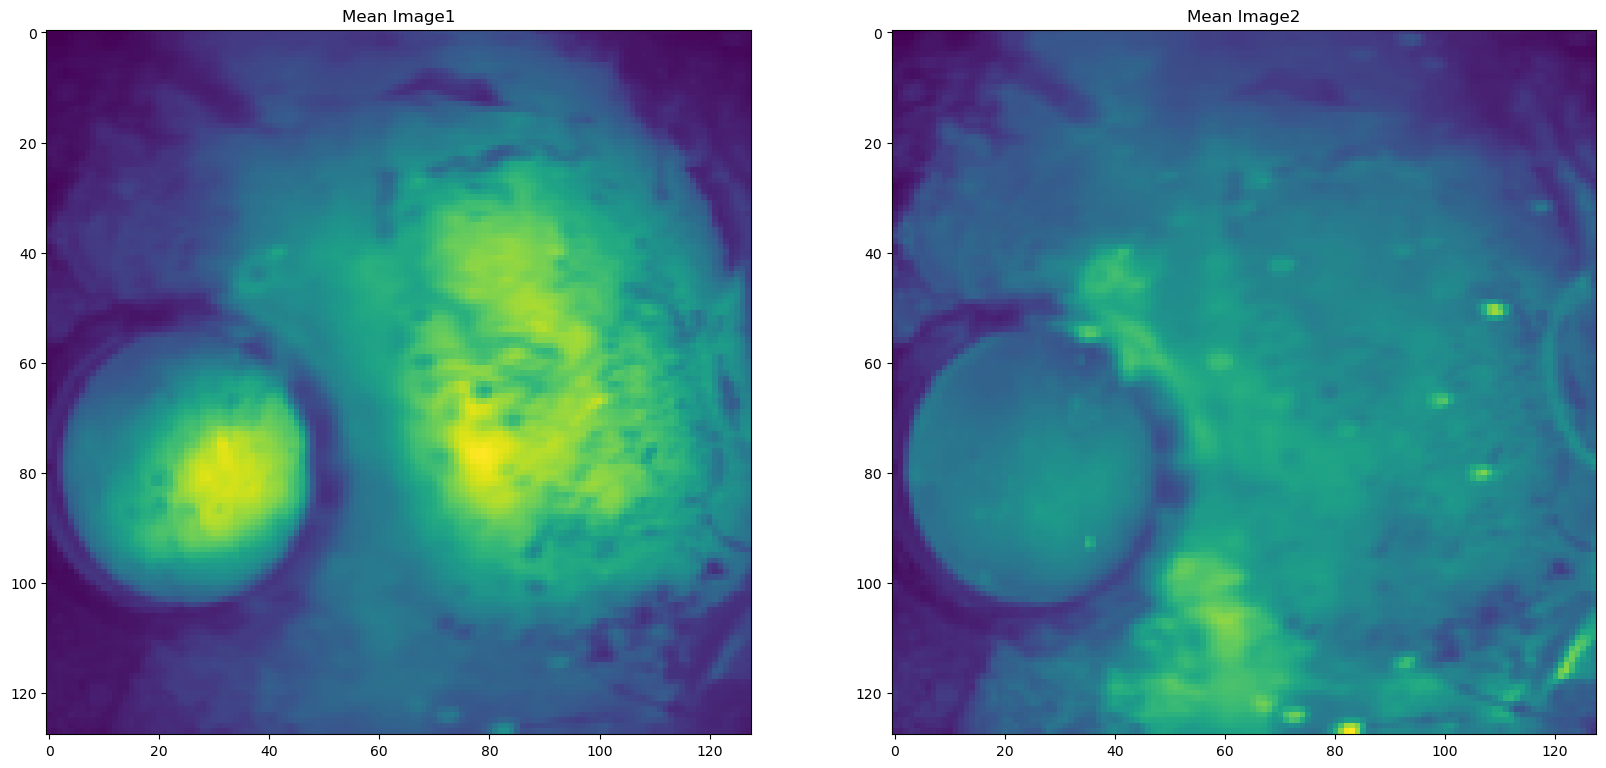

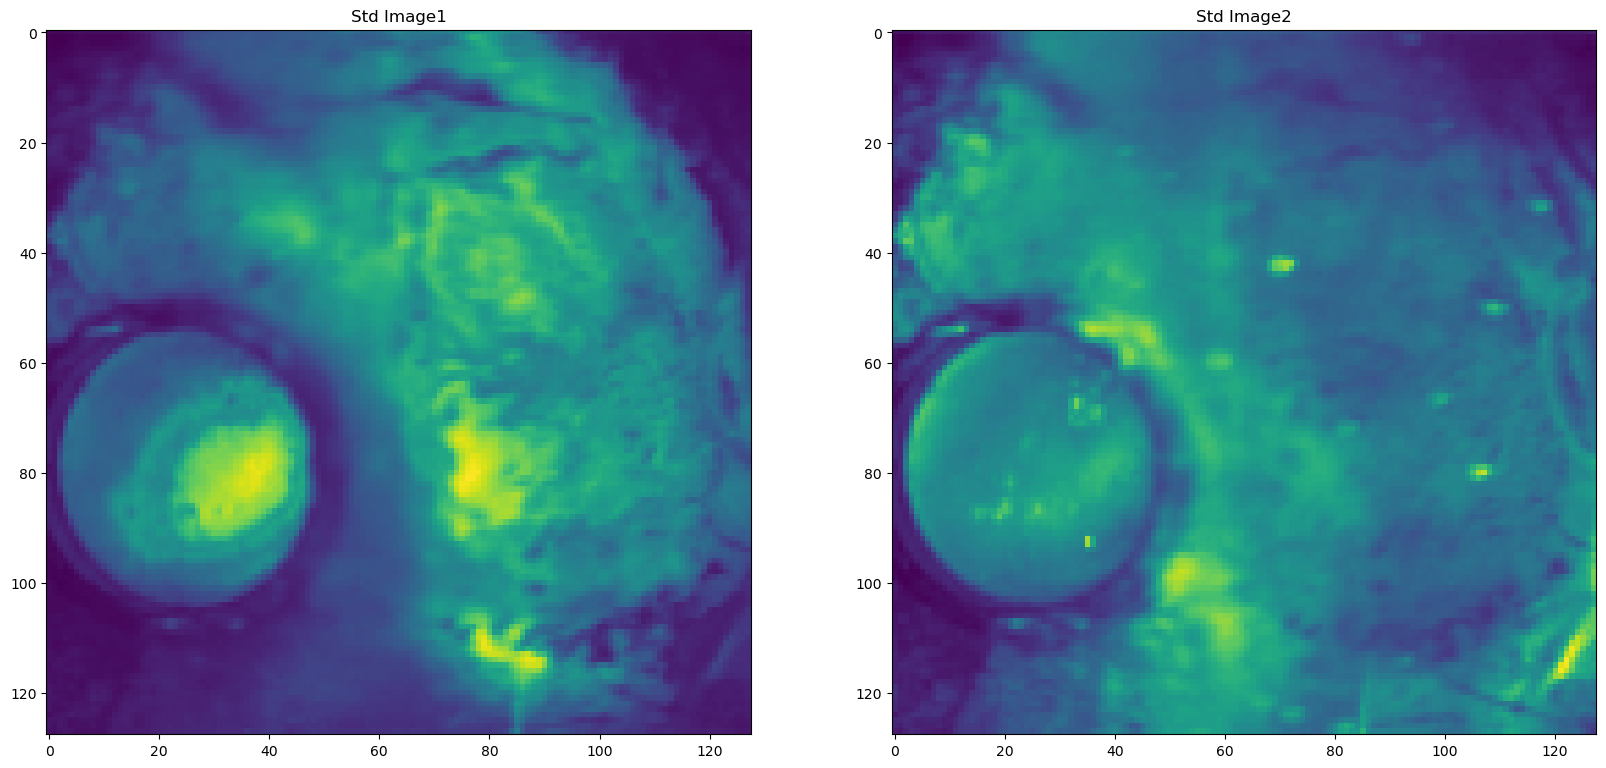

In [2]:
import matplotlib.pyplot as plt

# mean images
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(dataset.mean1)
ax[0].set_title("Mean Image1")
ax[1].imshow(dataset.mean2)
ax[1].set_title("Mean Image2")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(dataset.std1)
ax[0].set_title("Std Image1")
ax[1].imshow(dataset.std2)
ax[1].set_title("Std Image2")
plt.show()

In [3]:
dataset.data[0].shape

(2, 128, 128)

In [4]:
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os, random
SEED = 2024

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [10]:
from torch import nn, optim

class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(123008, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )
    
    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, shuffle=True)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [13]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

net = CNN(n_output=2, n_hidden=128).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.Adam(net.parameters(), lr=lr)

num_epochs = 5

========== Epoch 1 Train ==========
train mean loss=0.36724689851204556, accuracy=0.8802083333333334
========== Epoch 1 Test
test mean loss=0.3457295447587967, accuracy=0.8916666666666667
========== Epoch 2 Train ==========
train mean loss=0.3667291462421417, accuracy=0.8802083333333334
========== Epoch 2 Test
test mean loss=0.3446099857489268, accuracy=0.8916666666666667
========== Epoch 3 Train ==========
train mean loss=0.36656150544683136, accuracy=0.8802083333333334
========== Epoch 3 Test
test mean loss=0.34334853092829387, accuracy=0.8916666666666667
========== Epoch 4 Train ==========
train mean loss=0.36651030033826826, accuracy=0.8802083333333334
========== Epoch 4 Test
test mean loss=0.34361555576324465, accuracy=0.8916666666666667
========== Epoch 5 Train ==========
train mean loss=0.3667538210749626, accuracy=0.8802083333333334
========== Epoch 5 Test
test mean loss=0.3431148260831833, accuracy=0.8916666666666667
========== Epoch 6 Train ==========
train mean loss=0.366532

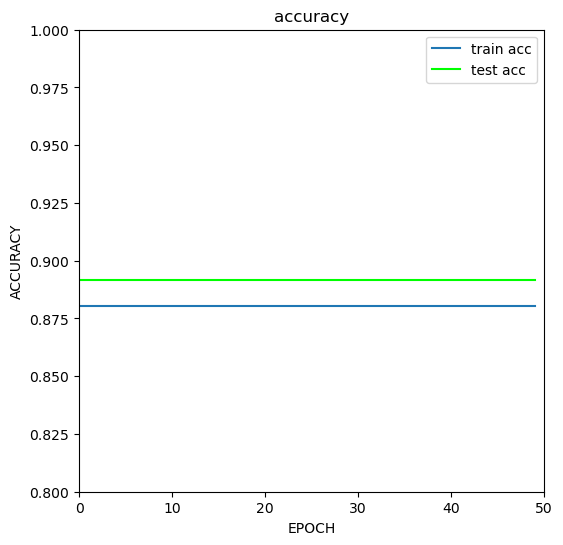

In [15]:
num_epochs = 15

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(num_epochs):
    print(f"========== Epoch {epoch+1} Train ==========")
    for (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0

    for (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
    
    print("train mean loss={}, accuracy={}"
          .format(sum_loss*32/len(train_loader.dataset), float(sum_correct/sum_total)))
    train_loss.append(sum_loss*32/len(train_loader.dataset))
    train_acc.append(float(sum_correct/sum_total))

    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0


    print(f"========== Epoch {epoch+1} Test")
    for (inputs, labels) in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
    
    print("test mean loss={}, accuracy={}"
          .format(sum_loss*32/len(test_loader.dataset), float(sum_correct/sum_total)))
    test_loss.append(sum_loss*32/len(test_loader.dataset))
    test_acc.append(float(sum_correct/sum_total))

plt.figure(figsize=(6,6))      #グラフ描画用

#以下グラフ描画
plt.plot(range(num_epochs), train_loss)
plt.plot(range(num_epochs), test_loss, c='#00ff00')
plt.xlim(0, num_epochs)
plt.ylim(0.8, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.clf()

plt.plot(range(num_epochs), train_acc)
plt.plot(range(num_epochs), test_acc, c='#00ff00')
plt.xlim(0, num_epochs)
plt.ylim(0.8, 1)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")